# EchoSpike

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from utils import test
from data import load_classwise_PMNIST, load_classwise_NMNIST
from model import EchoSpike, simple_out
import numpy as np
import torch
import seaborn as sns
from scipy.signal import savgol_filter
import pickle
from main import Args
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 600
plt.rcParams.update({'font.size': 18})

color_list = sns.color_palette('muted')
device = 'cpu'
folder = 'models/'
model_name = 'online_nmnist.pt'
with open(folder + model_name[:-3] + '_args.pkl', 'rb') as f:
    args = pickle.load(f)
args.augment = False
args.inp_threshold = 0.01
# args = Args()
print(vars(args))
args.device = device

/home/lars/miniconda3/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/lars/miniconda3/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in

{'model_name': 'online_nmnist', 'dataset': 'nmnist', 'online': True, 'device': 'cuda', 'recurrency_type': 'none', 'lr': 0.0005, 'epochs': 300, 'augment': False, 'batch_size': 128, 'n_hidden': [200, 200, 200], 'c_y': [0.0001, -0.0001], 'n_inputs': 2312, 'n_outputs': 10, 'n_time_bins': 10, 'beta': 0.9, 'inp_threshold': 0.01}


## Dataset
N-MNIST 


(34, 34, 2)


/home/lars/ownCloud/ETH/Master/Project_2/SNN_CLAPP/data.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


torch.Size([10, 1, 2312]) Target Digit: 4


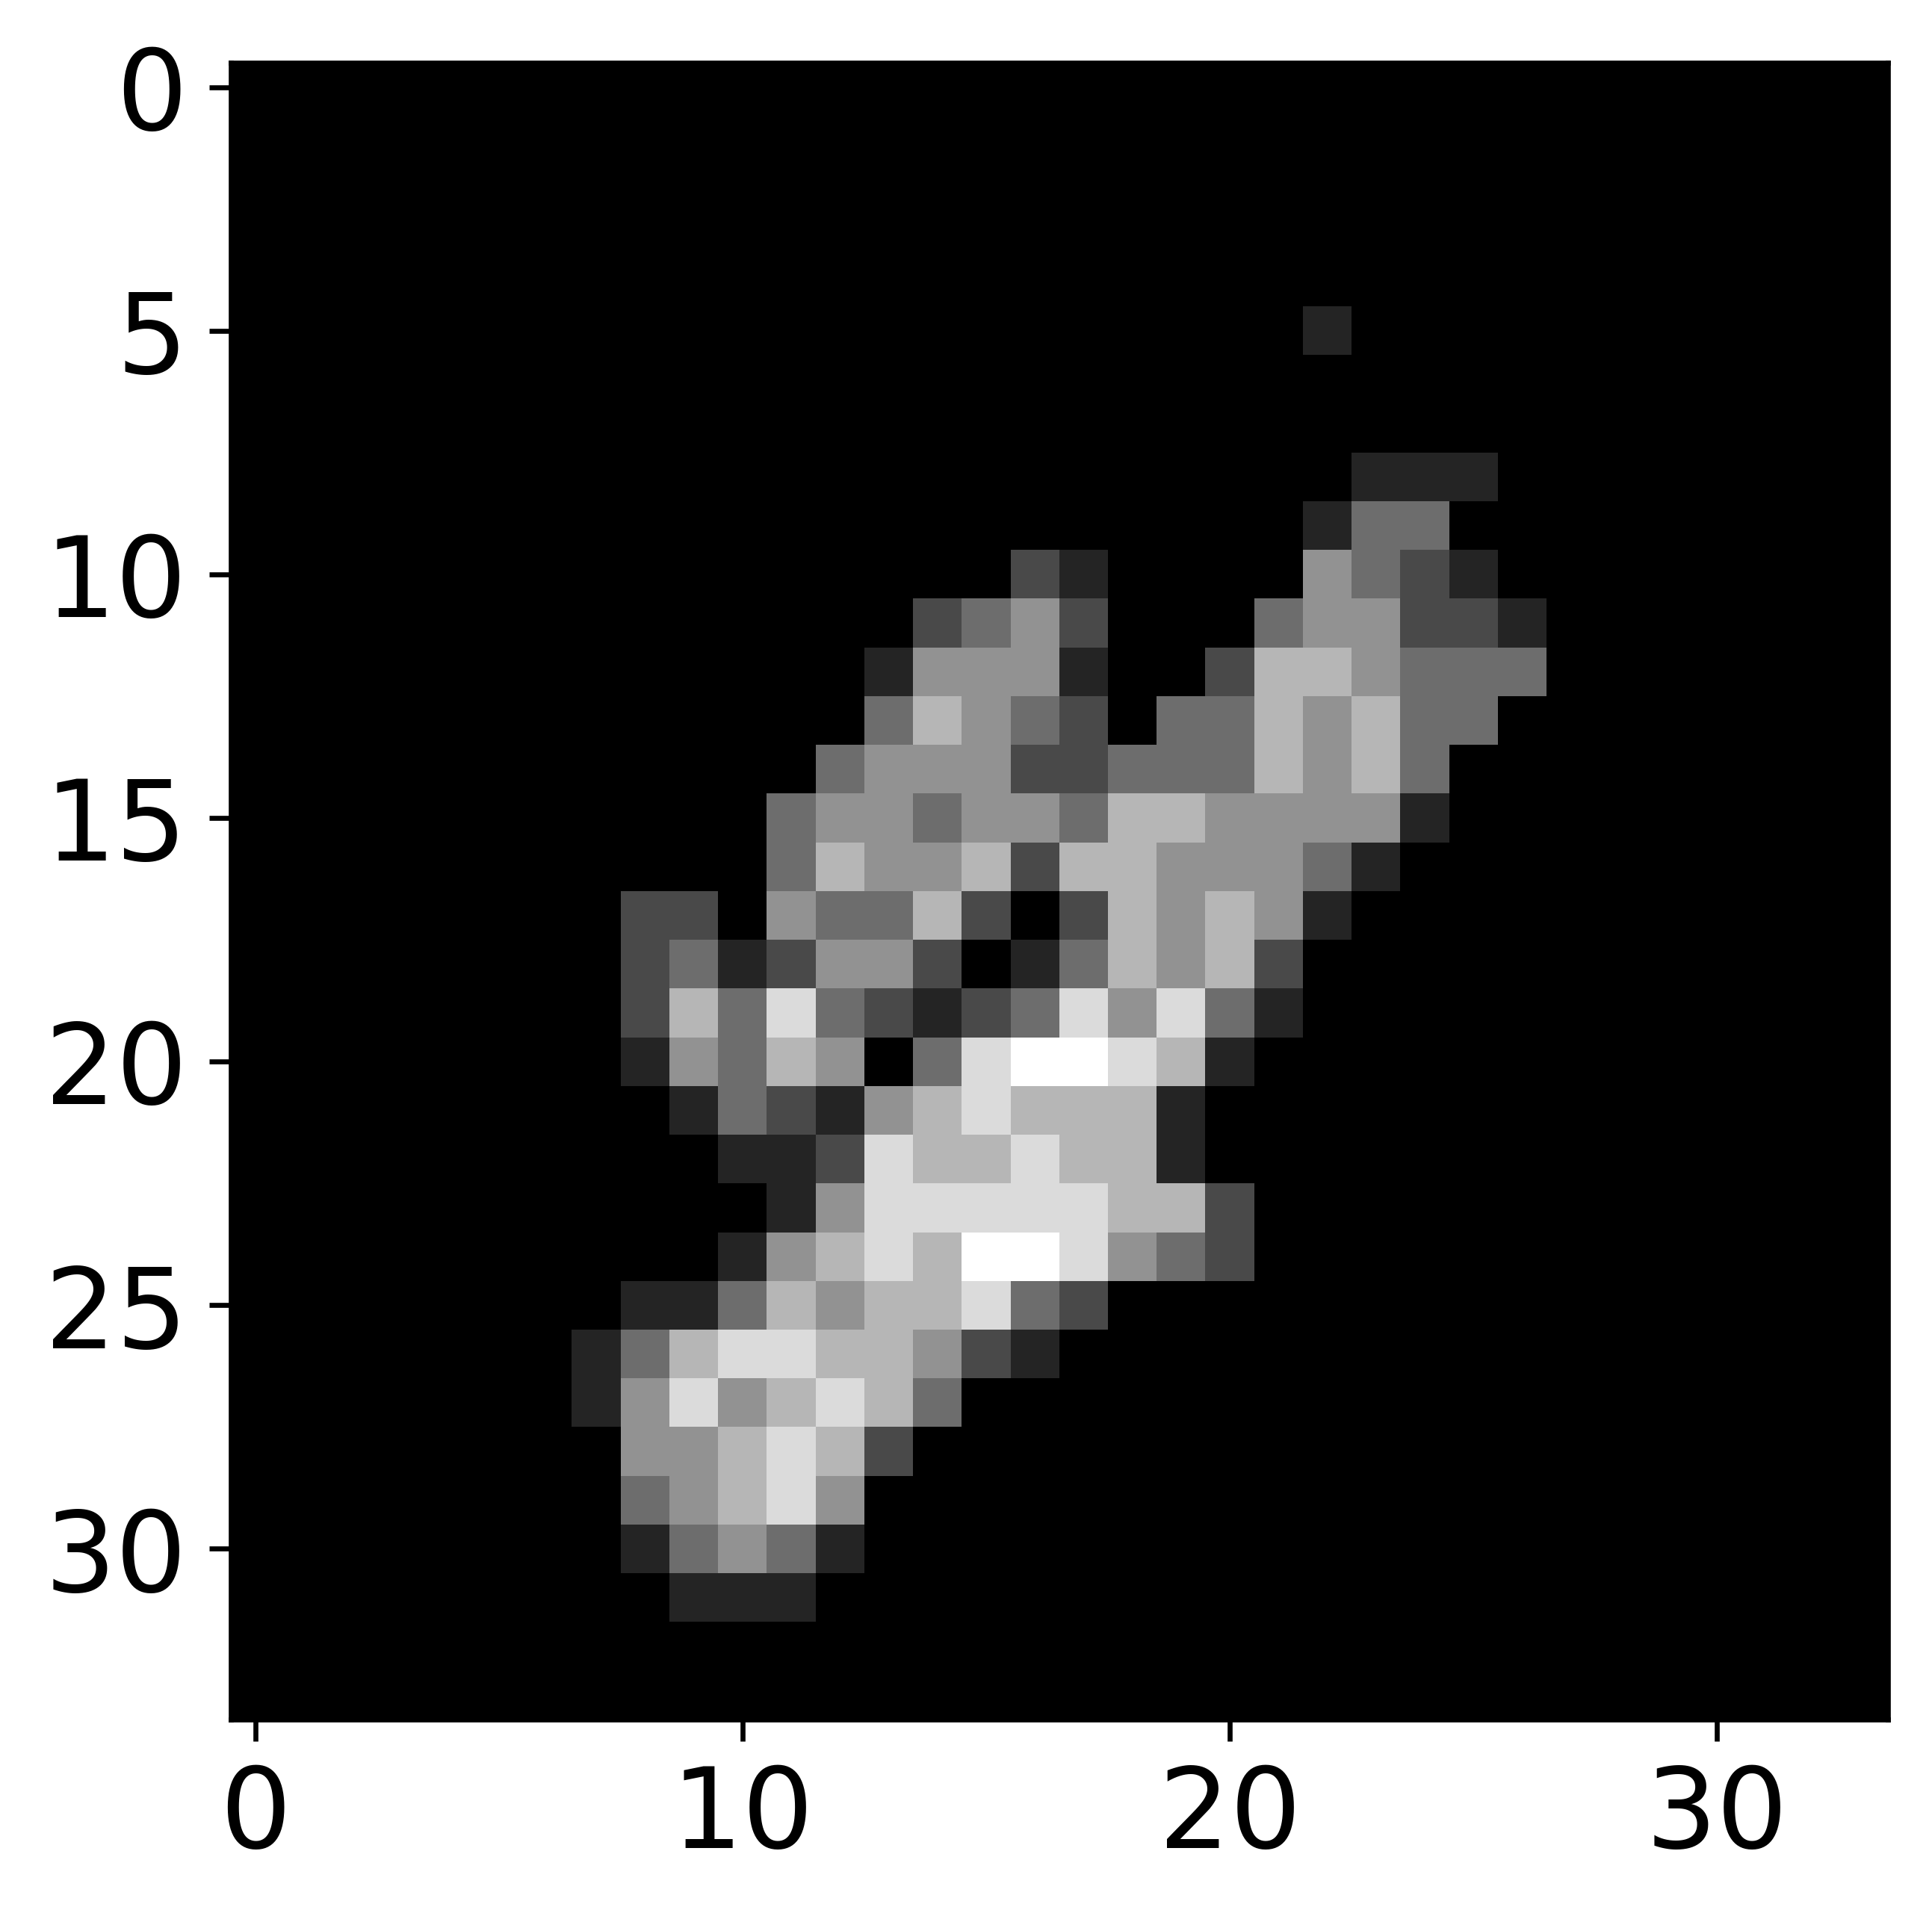

In [2]:
if args.dataset == 'mnist':
    train_loader, train_loader2, test_loader = load_classwise_PMNIST(args.n_time_bins, scale=args.poisson_scale, split_train=True) #load_NMNIST(n_time_bins, batch_size=batch_size)
else:
    train_loader, train_loader2, test_loader = load_classwise_NMNIST(args.n_time_bins, split_train=True)
# Plot Example
frames, target = train_loader.next_item(-1)
print(frames.shape, f'Target Digit: {target.item()}')
plt.figure()
if args.dataset == 'mnist':
    plt.imshow(frames[0].view(28,28), cmap='gray')
else:
    plt.imshow(frames.squeeze().sum(axis=0).view(2,34,34)[0], cmap='gray')

## Load pretrained model

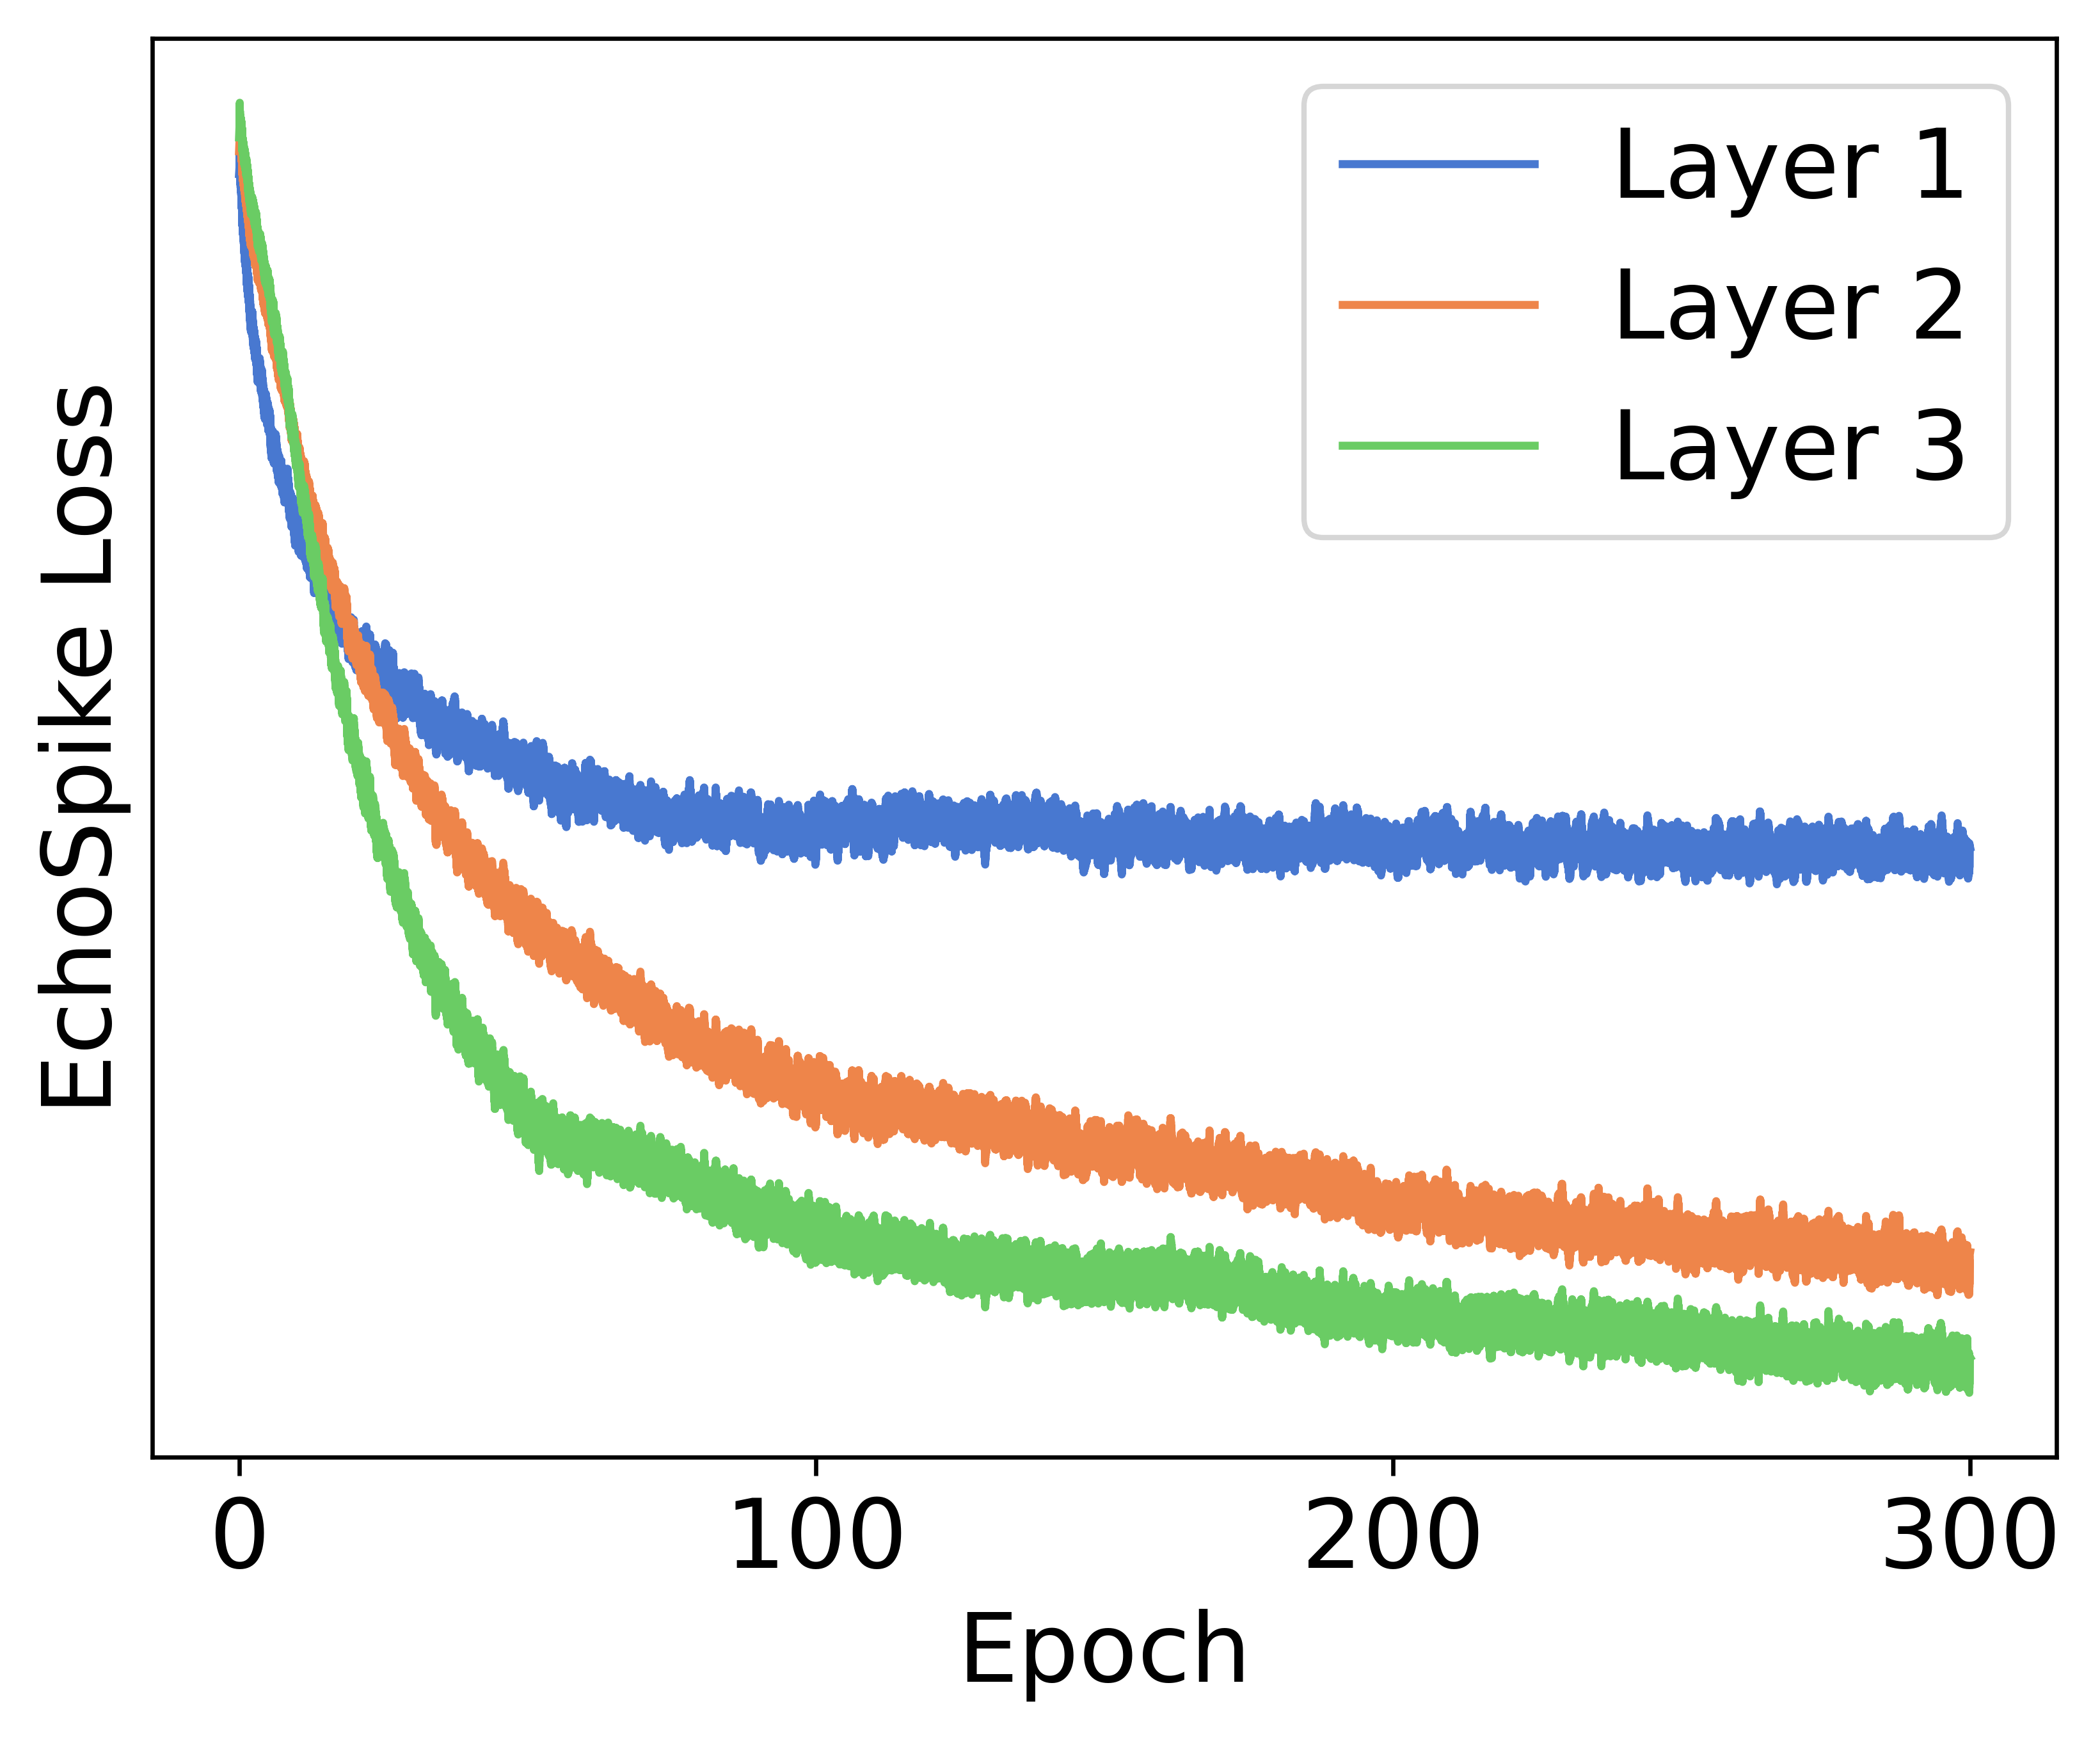

In [3]:
SNN = EchoSpike(args.n_inputs, args.n_hidden, c_y=args.c_y, beta=args.beta, recurrency_type=args.recurrency_type).to(device)
# state_dict = torch.load(folder+model_name, map_location=args.device)
# state_dict = {key.replace('clapp', 'layers'):value for key, value in state_dict.items()}
# # overwrite the state dict
# torch.save(state_dict, folder+model_name)
SNN.load_state_dict(torch.load(folder+model_name, map_location=device))
# Load and Plot train loss history
echo_train_losses = torch.load(f'{folder+model_name[:-3]}_loss_hist.pt', map_location=device)
for i in range(echo_train_losses.shape[1]):
    plt.plot(np.linspace(0, args.epochs, len(echo_train_losses)), savgol_filter(echo_train_losses[:,i], 99, 1), label=f'Layer {i+1}', color=color_list[i])
plt.ylabel('EchoSpike Loss')
# no y ticks, because it's not really meaningful
plt.yticks([])
plt.xlabel('Epoch')
# plt.title('EchoSpike Loss During Training for Each Layer');
plt.legend();

# Run EchoSpike on the test set and get hidden states

In [4]:
echo_activation, target_list, echo_losses = test(SNN, test_loader, device, batch_size=args.batch_size)
print(f'EchoSpike loss per layer: {torch.stack(echo_losses).mean(axis=0).numpy()}')

EchoSpike loss per layer: [-0.8859333 -1.3214357 -1.3997529]


# Analyze Weights Directly

In [ ]:
layers = [SNN.layers[0].fc.weight]
for i in range(1, len(SNN.layers)):
    layers.append(SNN.layers[i].fc.weight @ layers[-1])

for i in range(len(SNN.layers)):
    plt.figure()
    plt.title(f'Layer {i}, Forward weights')
    plt.imshow(SNN.layers[i].fc.weight.detach())
    plt.colorbar()
for lidx, lay in enumerate(layers):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Receptive field, Layer {lidx}')
    for i in range(3):
        if args.dataset == 'mnist':
            axs[i].imshow(lay[i].view(28, 28).detach())
        else:
            axs[i].imshow(lay[i].view(2, 34, 34)[0].detach())

# Plot the projections of the hidden states

In [ ]:
print(len(echo_activation))
hidden_activities_transformed = [[] for i in range(len(args.n_hidden))]
for ca in echo_activation:
    for ca_layer in range(len(ca)):
        hidden_activities_transformed[ca_layer].append(ca[ca_layer])
for ha_idx in range(len(args.n_hidden)):
    hidden_activities_transformed[ha_idx] = torch.stack(hidden_activities_transformed[ha_idx]).reshape(-1, hidden_activities_transformed[ha_idx][0].shape[-1])

target_transformed = torch.stack(target_list).flatten()
print(hidden_activities_transformed[0].shape, target_transformed.shape)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# transform = TSNE()
transform = PCA()
# transform = UMAP()
colors = [color_list[i.int()] for i in target_transformed]

for hat in hidden_activities_transformed:
    # Number of Neurons that never spiked during the test set
    print(f'{(hat.sum(axis=0) == 0).sum()} dead neurons')
    hat_transform = transform.fit_transform(hat.detach().cpu().numpy())
    plt.figure(figsize=(8,8))
    col = colors
    # Plot each digit separately, this makes it easier to color and label them
    for i in range(args.n_outputs):
        col_indeces = np.argwhere(target_transformed.squeeze() == i).squeeze()
        hattt = hat_transform[col_indeces, :]
        plt.scatter(hattt[:,0], hattt[:,1], s=6, color=color_list[i], label=i, alpha=0.4)
    plt.legend()


# Train output Projection From Each layer and from Inputs directly

In [6]:
from tqdm.notebook import tqdm

def train_out_proj(epochs, batch, out_projs=None, cat=False, lr=1e-2):
    # train output projections from all layers (and no layer)
    dataloader = train_loader2
    losses_out = []
    optimizers = []
    print_interval = 10*batch
    if out_projs is None:
        out_projs = []
        out_proj_0 = simple_out(args.n_inputs, args.n_outputs, beta=1.0)
    else:
        for out_p in out_projs:
            out_p.train()
            out_p.reset()
        out_proj_0 = out_projs[0]
        out_projs = out_projs[1:]
    optim_0 = torch.optim.Adam(out_proj_0.parameters(), lr=lr)
    for lay in range(len(SNN.layers)):
        if len(out_projs) <= lay:
            if cat:
                out_projs.append(simple_out(sum(args.n_hidden[:lay+1]) + args.n_inputs, args.n_outputs, beta=1.0))
            else:
                out_projs.append(simple_out(args.n_hidden[lay], args.n_outputs, beta=1.0))
        optimizers.append(torch.optim.Adam(out_projs[lay].parameters(), lr=lr))
        optimizers[-1].zero_grad()
    SNN.eval()
    target = batch*[0]
    acc = []
    correct = (len(SNN.layers) + 1)*[0]
    with torch.no_grad():
        pbar = tqdm(total=len(dataloader)*epochs)
        while len(losses_out)*batch < len(dataloader)*epochs:
            data, target = dataloader.next_item(target, contrastive=True)
            SNN.reset(0)
            logit_lists = [[] for lay in range(len(SNN.layers)+1)]
            data = data.squeeze()
            for step in range(data.shape[0]):
                data_step = data[step].float().to(device)
                target = target.to(device)
                logits, _, _ = SNN(data_step, 0)
                if step == args.n_time_bins-1:
                    _, logts = out_proj_0(data_step, target)
                    logit_lists[0] = logts
                    for lay in range(len(SNN.layers)):
                        if cat:
                            _, logts = out_projs[lay](torch.cat([data_step, *logits[:lay+1]], dim=-1), target)
                        else:
                            _, logts = out_projs[lay](logits[lay], target)
                        logit_lists[lay+1] = logts
                else:
                    out_proj_0(data_step, None)
                    for lay in range(len(SNN.layers)):
                        if cat:
                            out_projs[lay](torch.cat([data_step, *logits[:lay+1]], dim=-1), None)
                        else:
                            out_projs[lay](logits[lay], None)
            
            preds = [logit_lists[lay].argmax(axis=-1) for lay in range(len(SNN.layers)+1)]
            # if pred.max() < 1: print(pred.max())
            dL = [preds[lay] == target for lay in range(len(SNN.layers)+1)]
            correct = [correct[lay] + dL[lay].sum() for lay in range(len(SNN.layers)+1)]
            out_proj_0.reset()
            for i, out_proj in enumerate(out_projs):
                out_proj.reset()

            losses_out.append(torch.tensor([torch.nn.functional.cross_entropy(logit_lists[lay], target.squeeze().long()) for lay in range(len(SNN.layers)+1)], requires_grad=False))

            optim_0.step()
            optim_0.zero_grad()
            for opt in optimizers:
                opt.step()
                opt.zero_grad()
            
            if len(losses_out)*batch % print_interval == 0:
                pbar.write(f'Cross Entropy Loss: {(torch.stack(losses_out)[-print_interval//batch:].sum(dim=0)/(print_interval//batch)).numpy()}\n' +
                           f'Correct: {100*np.array(correct)/print_interval}%')
                acc.append(np.array(correct)/print_interval)
                correct = (len(SNN.layers) + 1)*[0]
            pbar.update(batch)
    return [out_proj_0, *out_projs], np.asarray(acc), torch.stack(losses_out)

def get_accuracy(dataloader, out_projs, cat=False):
    correct = torch.zeros(len(out_projs))
    for out_proj in out_projs:
        out_proj.eval()
    SNN.eval()
    total = 0
    pred_matrix = torch.zeros(args.n_outputs, args.n_outputs)
    for idx in trange(0, len(dataloader), args.batch_size):
        for out_proj in out_projs:
            out_proj.reset()
        SNN.reset(0)
        if args.dataset == 'mnist':
            inp, target = dataloader.x[idx:idx+args.batch_size], dataloader.y[idx:idx+args.batch_size]
        else:
            flattenend_indeces = torch.cat(dataloader.target_indeces)
            indeces = flattenend_indeces[idx:idx+args.batch_size]
            until = min(args.batch_size, len(dataloader) - idx)
            inp = torch.stack([torch.tensor(dataloader.data[indeces[i]][0]).view(args.n_time_bins, -1) for i in range(until)])
            target = torch.tensor([dataloader.data[indeces[i]][1] for i in range(until)])
        logits = len(out_projs)*[torch.zeros((inp.shape[0],args.n_outputs))]
        for step in range(inp.shape[1]):
            data_step = inp[:,step].float().to(device)
            spk_step, _, _ = SNN(data_step, 0)
            spk_step = [data_step, *spk_step]
            for i, out_proj in enumerate(out_projs):
                if cat:
                    _, mem = out_proj(torch.cat(spk_step[:i+1], dim=-1), target)
                else:
                    _, mem = out_proj(spk_step[i], target)
                if step == args.n_time_bins-1:
                    logits[i] = mem
        total += inp.shape[0]
        for i, logit in enumerate(logits):
            pred = logit.argmax(axis=-1)
            correct[i] += int((pred == target).sum())
        # for the last layer create the prediction matrix
        for j in range(pred.shape[0]):
            pred_matrix[int(target[j]), int(pred[j])] += 1
    correct /= len(dataloader)
    assert total == len(dataloader)
    print('Directly from inputs:')
    print(f'Accuracy: {100*correct[0]:.2f}%')
    for i in range(len(out_projs)-1):
        print(f'From layer {i+1}:')
        print(f'Accuracy: {100*correct[i+1]:.2f}%')
    return correct, pred_matrix

with torch.no_grad():
    cat = False
    # repeat 10 times
    test_accs = []
    train_accs = []
    for i in range(10):
        # new random seed
        torch.manual_seed(i)
        out_projs, acc, losses_out = train_out_proj(1, 32, cat=cat, lr=1e-2)
        test_accs.append(get_accuracy(test_loader, out_projs, cat=cat)[0])
        train_accs.append(get_accuracy(train_loader2, out_projs, cat=cat)[0])

  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [5.5295835 1.1930945 1.0164381 0.8238064]
Correct: [42.5    70.     74.375  82.8125]%
Cross Entropy Loss: [2.5315812  0.2705192  0.19352986 0.19454774]
Correct: [66.25   95.     95.     95.3125]%
Cross Entropy Loss: [1.5776343  0.2111036  0.19501421 0.19625048]
Correct: [78.75   94.0625 95.     95.625 ]%
Cross Entropy Loss: [1.469233   0.19258913 0.17091039 0.16779566]
Correct: [81.875  95.     95.     94.6875]%
Cross Entropy Loss: [0.90845585 0.15307628 0.14796218 0.16556954]
Correct: [85.9375 96.25   96.25   95.9375]%
Cross Entropy Loss: [1.4799249  0.17428559 0.20021236 0.20039177]
Correct: [83.125  94.6875 94.375  93.75  ]%
Cross Entropy Loss: [1.1970506  0.12683919 0.1181947  0.12085849]
Correct: [82.5    95.625  95.9375 95.3125]%
Cross Entropy Loss: [1.3513414  0.14802058 0.14613865 0.14379124]
Correct: [82.8125 96.25   95.     95.    ]%
Cross Entropy Loss: [1.3586342  0.20103607 0.20846578 0.19727784]
Correct: [83.75   94.375  94.6875 95.    ]%
Cross Entropy 

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 87.71%
From layer 1:
Accuracy: 95.00%
From layer 2:
Accuracy: 95.32%
From layer 3:
Accuracy: 95.37%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 89.47%
From layer 1:
Accuracy: 96.60%
From layer 2:
Accuracy: 96.00%
From layer 3:
Accuracy: 96.07%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [4.743554  1.3478799 1.1089827 1.108496 ]
Correct: [43.75   65.9375 71.875  70.3125]%
Cross Entropy Loss: [1.4901136  0.27516907 0.18171111 0.18517843]
Correct: [76.875  95.3125 95.625  96.5625]%
Cross Entropy Loss: [1.06442    0.15321124 0.12691729 0.13854527]
Correct: [86.25   95.9375 96.875  96.5625]%
Cross Entropy Loss: [1.9385338  0.21664536 0.23672357 0.2106862 ]
Correct: [77.8125 93.4375 94.6875 94.6875]%
Cross Entropy Loss: [1.496927   0.15350534 0.13262269 0.13558432]
Correct: [82.8125 95.625  95.9375 95.625 ]%
Cross Entropy Loss: [1.2816118  0.2064108  0.21852687 0.19871123]
Correct: [85.     93.4375 93.75   93.75  ]%
Cross Entropy Loss: [1.1777828  0.14683333 0.16076593 0.15721546]
Correct: [79.375  95.625  96.25   96.5625]%
Cross Entropy Loss: [0.87285745 0.13967761 0.14682294 0.135951  ]
Correct: [87.1875 97.5    96.875  97.1875]%
Cross Entropy Loss: [1.0465918  0.15198609 0.1343035  0.16127017]
Correct: [87.1875 95.3125 95.9375 96.25  ]%
Cross Entropy 

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 84.96%
From layer 1:
Accuracy: 95.43%
From layer 2:
Accuracy: 95.60%
From layer 3:
Accuracy: 95.55%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 85.40%
From layer 1:
Accuracy: 96.67%
From layer 2:
Accuracy: 96.38%
From layer 3:
Accuracy: 96.22%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [6.3685145  1.1565137  0.86928904 0.8038435 ]
Correct: [41.5625 71.25   75.625  80.625 ]%
Cross Entropy Loss: [2.6177404  0.28909692 0.20588243 0.21720192]
Correct: [70.625  92.5    95.3125 93.75  ]%
Cross Entropy Loss: [1.8101084  0.16266479 0.17284994 0.15046094]
Correct: [81.5625 96.25   95.3125 95.625 ]%
Cross Entropy Loss: [2.1623416  0.16567911 0.20031457 0.19845514]
Correct: [76.5625 95.3125 95.     94.375 ]%
Cross Entropy Loss: [1.116925   0.15408011 0.14499916 0.1448884 ]
Correct: [84.0625 95.     95.9375 95.    ]%
Cross Entropy Loss: [1.2563428  0.19621906 0.19643469 0.2010707 ]
Correct: [84.0625 95.3125 95.625  95.625 ]%
Cross Entropy Loss: [1.983222   0.24409664 0.24221563 0.24172473]
Correct: [82.8125 93.125  93.125  92.8125]%
Cross Entropy Loss: [1.2458996  0.16575274 0.16362998 0.1734445 ]
Correct: [84.0625 96.5625 96.25   96.5625]%
Cross Entropy Loss: [1.1346118  0.15856607 0.16152549 0.19116847]
Correct: [85.3125 96.875  96.875  96.25  ]%
Cross Entr

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 83.79%
From layer 1:
Accuracy: 95.44%
From layer 2:
Accuracy: 95.56%
From layer 3:
Accuracy: 95.52%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 84.58%
From layer 1:
Accuracy: 96.52%
From layer 2:
Accuracy: 96.33%
From layer 3:
Accuracy: 95.90%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [5.874399   1.1195347  0.80821484 0.8990475 ]
Correct: [42.1875 72.1875 77.1875 76.875 ]%
Cross Entropy Loss: [1.8010181  0.22090928 0.13424958 0.13072732]
Correct: [72.1875 96.5625 96.875  97.5   ]%
Cross Entropy Loss: [1.1820569  0.19306327 0.17157379 0.17649758]
Correct: [81.25   93.75   94.0625 94.0625]%
Cross Entropy Loss: [1.3387374  0.15323886 0.14377935 0.12841676]
Correct: [83.75  96.25  96.875 96.875]%
Cross Entropy Loss: [0.8826949  0.12022243 0.14477745 0.1435369 ]
Correct: [86.875 96.875 96.875 96.875]%
Cross Entropy Loss: [1.627421   0.2406601  0.2584643  0.27709186]
Correct: [83.4375 91.25   92.1875 91.25  ]%
Cross Entropy Loss: [1.7550122  0.2015008  0.2058646  0.18862692]
Correct: [79.375  94.6875 95.3125 95.    ]%
Cross Entropy Loss: [1.6428976  0.135876   0.11994018 0.12160991]
Correct: [82.8125 95.9375 96.25   96.5625]%
Cross Entropy Loss: [1.7050436  0.17755425 0.18481214 0.18490064]
Correct: [82.1875 95.9375 95.625  96.25  ]%
Cross Entropy Loss

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 87.21%
From layer 1:
Accuracy: 95.32%
From layer 2:
Accuracy: 95.23%
From layer 3:
Accuracy: 95.17%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 89.20%
From layer 1:
Accuracy: 96.45%
From layer 2:
Accuracy: 96.15%
From layer 3:
Accuracy: 95.97%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [5.856494   1.1829805  0.94136417 1.0116652 ]
Correct: [37.8125 70.625  74.0625 73.75  ]%
Cross Entropy Loss: [1.9465319  0.24497803 0.15118985 0.16559838]
Correct: [72.8125 96.5625 96.5625 96.25  ]%
Cross Entropy Loss: [1.279161   0.18845879 0.17665128 0.17995796]
Correct: [82.1875 95.     95.     94.375 ]%
Cross Entropy Loss: [1.2753228  0.17447242 0.18785398 0.17724982]
Correct: [84.0625 96.25   96.5625 95.625 ]%
Cross Entropy Loss: [0.976501   0.17651713 0.18461138 0.19303659]
Correct: [84.6875 93.4375 93.75   94.0625]%
Cross Entropy Loss: [1.108259   0.13691057 0.13959837 0.12101498]
Correct: [85.    96.25  96.25  96.875]%
Cross Entropy Loss: [1.415191   0.16379729 0.16428128 0.17382997]
Correct: [83.4375 95.9375 96.875  96.875 ]%
Cross Entropy Loss: [0.9412491  0.12373932 0.14006731 0.12870967]
Correct: [83.125  96.5625 96.25   96.5625]%
Cross Entropy Loss: [1.0487261  0.12333502 0.11676624 0.13719293]
Correct: [85.     96.5625 97.5    96.5625]%
Cross Entropy 

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 86.77%
From layer 1:
Accuracy: 95.20%
From layer 2:
Accuracy: 95.31%
From layer 3:
Accuracy: 95.15%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 87.43%
From layer 1:
Accuracy: 96.62%
From layer 2:
Accuracy: 96.27%
From layer 3:
Accuracy: 95.83%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [5.496236  1.0492316 0.7914134 0.895106 ]
Correct: [45.     75.625  83.125  80.3125]%
Cross Entropy Loss: [1.620817   0.23298553 0.16876797 0.18911967]
Correct: [75.     94.6875 95.     95.625 ]%
Cross Entropy Loss: [1.0626566  0.15881476 0.13259326 0.14811602]
Correct: [84.375 95.625 96.25  96.25 ]%
Cross Entropy Loss: [1.3332021  0.14906748 0.18513256 0.17885871]
Correct: [82.8125 96.5625 95.3125 95.9375]%
Cross Entropy Loss: [1.6284735  0.19155402 0.18986271 0.16968356]
Correct: [79.0625 94.6875 95.     95.3125]%
Cross Entropy Loss: [1.371633   0.1608577  0.17567773 0.17382033]
Correct: [82.1875 95.     94.375  94.6875]%
Cross Entropy Loss: [1.3782933  0.150902   0.15424374 0.17523506]
Correct: [81.875  94.375  93.75   94.0625]%
Cross Entropy Loss: [1.158122   0.17369978 0.17937092 0.16488776]
Correct: [84.6875 95.625  95.3125 96.5625]%
Cross Entropy Loss: [0.92279017 0.12097836 0.13642947 0.11189766]
Correct: [87.1875 96.25   95.     96.25  ]%
Cross Entropy Loss

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 82.38%
From layer 1:
Accuracy: 95.47%
From layer 2:
Accuracy: 95.52%
From layer 3:
Accuracy: 95.50%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 83.03%
From layer 1:
Accuracy: 96.67%
From layer 2:
Accuracy: 96.30%
From layer 3:
Accuracy: 96.02%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [6.3613634  1.0954243  0.89197445 0.7666893 ]
Correct: [33.75   70.9375 79.6875 82.5   ]%
Cross Entropy Loss: [2.1134398  0.27810752 0.17713028 0.17042573]
Correct: [70.     94.375  95.625  95.9375]%
Cross Entropy Loss: [1.7423637  0.22917488 0.20996042 0.22752519]
Correct: [79.0625 94.6875 95.3125 95.625 ]%
Cross Entropy Loss: [1.6496029  0.1777431  0.16752616 0.16104697]
Correct: [77.8125 94.0625 95.3125 95.3125]%
Cross Entropy Loss: [1.6503675  0.24839976 0.23583117 0.2577211 ]
Correct: [83.75   94.0625 95.     94.375 ]%
Cross Entropy Loss: [0.9344778  0.17322749 0.19551387 0.19132389]
Correct: [85.9375 95.9375 94.6875 94.6875]%
Cross Entropy Loss: [1.8780692  0.202387   0.19485727 0.19842574]
Correct: [81.875  92.8125 93.4375 93.4375]%
Cross Entropy Loss: [1.3980231  0.21011719 0.20831764 0.23583785]
Correct: [82.1875 93.4375 94.6875 94.6875]%
Cross Entropy Loss: [0.78363717 0.12273101 0.11483826 0.1160337 ]
Correct: [89.375  97.1875 96.875  97.5   ]%
Cross Entr

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 86.69%
From layer 1:
Accuracy: 95.19%
From layer 2:
Accuracy: 95.20%
From layer 3:
Accuracy: 95.21%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 89.08%
From layer 1:
Accuracy: 96.28%
From layer 2:
Accuracy: 96.02%
From layer 3:
Accuracy: 95.80%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [5.2624288  1.2183607  0.91743374 0.85061884]
Correct: [42.1875 65.     76.25   81.875 ]%
Cross Entropy Loss: [2.1387172  0.2803634  0.19736663 0.19066997]
Correct: [69.6875 94.375  95.9375 96.25  ]%
Cross Entropy Loss: [2.1744475  0.22453876 0.22833137 0.2228001 ]
Correct: [75.625 94.375 94.375 95.   ]%
Cross Entropy Loss: [1.6828325  0.18038721 0.21128452 0.2161527 ]
Correct: [80.3125 94.6875 95.3125 95.    ]%
Cross Entropy Loss: [1.445265   0.14950192 0.15715376 0.1601819 ]
Correct: [81.25   94.6875 95.625  94.6875]%
Cross Entropy Loss: [1.4091928  0.10695024 0.09727111 0.09554513]
Correct: [84.375 96.875 96.875 97.5  ]%
Cross Entropy Loss: [1.5807569  0.19362463 0.16474718 0.1804674 ]
Correct: [83.4375 94.0625 95.     94.375 ]%
Cross Entropy Loss: [1.0984333  0.17324486 0.1956659  0.20741978]
Correct: [86.5625 94.375  94.0625 94.0625]%
Cross Entropy Loss: [1.6202624  0.18098775 0.22341414 0.21856698]
Correct: [80.9375 95.     94.375  94.0625]%
Cross Entropy Loss

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 84.32%
From layer 1:
Accuracy: 95.47%
From layer 2:
Accuracy: 95.61%
From layer 3:
Accuracy: 95.46%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 85.22%
From layer 1:
Accuracy: 96.53%
From layer 2:
Accuracy: 96.57%
From layer 3:
Accuracy: 96.20%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [3.6309948  1.0325272  0.9282406  0.92323923]
Correct: [52.8125 75.3125 75.9375 78.4375]%
Cross Entropy Loss: [2.021596   0.27331954 0.21561977 0.23070209]
Correct: [75.     93.75   95.3125 95.3125]%
Cross Entropy Loss: [1.8908297  0.17474684 0.15148532 0.1596999 ]
Correct: [77.1875 95.     95.625  95.3125]%
Cross Entropy Loss: [1.3159072  0.15934733 0.19160363 0.20191157]
Correct: [80.    95.625 96.25  95.625]%
Cross Entropy Loss: [1.2660388  0.1420131  0.13397446 0.13058779]
Correct: [81.25   93.75   95.9375 95.9375]%
Cross Entropy Loss: [1.2399851  0.19824407 0.18400584 0.16375391]
Correct: [84.6875 94.375  95.3125 95.9375]%
Cross Entropy Loss: [1.5206597 0.1824938 0.2098799 0.2027516]
Correct: [81.5625 94.6875 95.9375 95.3125]%
Cross Entropy Loss: [1.3032138  0.18301043 0.18353565 0.18463632]
Correct: [85.3125 95.625  96.25   95.9375]%
Cross Entropy Loss: [1.4563459  0.17970659 0.18755694 0.1878261 ]
Correct: [80.3125 93.125  94.6875 94.375 ]%
Cross Entropy Loss

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 85.23%
From layer 1:
Accuracy: 94.93%
From layer 2:
Accuracy: 95.53%
From layer 3:
Accuracy: 95.34%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 88.22%
From layer 1:
Accuracy: 96.63%
From layer 2:
Accuracy: 96.40%
From layer 3:
Accuracy: 96.02%


  0%|          | 0/6000 [00:00<?, ?it/s]

Cross Entropy Loss: [6.6754656  1.2837188  0.81860936 0.9430617 ]
Correct: [38.75   64.0625 79.0625 81.25  ]%
Cross Entropy Loss: [2.97419    0.2654386  0.14697452 0.15739739]
Correct: [67.1875 95.     96.25   95.625 ]%
Cross Entropy Loss: [2.5662134  0.2026008  0.19641621 0.1703529 ]
Correct: [70.3125 93.75   94.6875 94.6875]%
Cross Entropy Loss: [1.7537884  0.22521766 0.22191867 0.22668597]
Correct: [75.625  93.4375 94.0625 94.375 ]%
Cross Entropy Loss: [1.3057983  0.17654772 0.19933651 0.19647193]
Correct: [82.1875 93.75   94.6875 94.0625]%
Cross Entropy Loss: [1.1579808  0.23222399 0.23378758 0.24175291]
Correct: [85.625  94.0625 95.     93.75  ]%
Cross Entropy Loss: [0.9539717  0.10560822 0.08437201 0.08338607]
Correct: [85.9375 96.875  97.8125 97.8125]%
Cross Entropy Loss: [1.4466012  0.19021961 0.18942797 0.19244948]
Correct: [84.375  94.0625 95.     94.375 ]%
Cross Entropy Loss: [0.93803465 0.14619784 0.14283171 0.14070344]
Correct: [83.4375 96.875  96.5625 96.5625]%
Cross Entr

  0%|          | 0/79 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 87.22%
From layer 1:
Accuracy: 95.30%
From layer 2:
Accuracy: 95.41%
From layer 3:
Accuracy: 95.24%


  0%|          | 0/47 [00:00<?, ?it/s]

Directly from inputs:
Accuracy: 88.15%
From layer 1:
Accuracy: 96.42%
From layer 2:
Accuracy: 96.18%
From layer 3:
Accuracy: 95.85%


In [ ]:
print(f'Accuracy of last quarter: {100*acc[-len(acc)//4:].mean(axis=0)}%')
plt.figure()
for i in range(acc.shape[1]):
    plt.plot(np.asarray(acc)[:,i]*100, color=color_list[i])
plt.ylabel('Accuracy [%]')
plt.xlabel('Training Step [x500]')
labels = ['From Inputs directly', *[f'From Layer {i+1}' for i in range(len(SNN.layers))]]
plt.legend(labels)
plt.ylim([90, 100])
plt.figure()
for i in range(losses_out.shape[1]):
    plt.plot(np.arange(len(losses_out))*args.batch_size/len(train_loader), savgol_filter(losses_out[:,i], 19, 1), label=labels[i], color=color_list[i])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylim([0, 0.6])
plt.legend();

## Test Accuracy on Test Set

In [6]:
correct, pred_matrix = get_accuracy(test_loader, out_projs, cat=cat)
plt.imshow(pred_matrix, origin='lower')
plt.title('Prediction Matrix for the final layer')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([i for i in range(args.n_outputs)])
plt.yticks([i for i in range(args.n_outputs)])
plt.colorbar();

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

torch.Size([10, 4])
Train Accuracy: tensor([86.9783, 96.5383, 96.2600, 95.9867])%, Std: tensor([2.2501, 0.1247, 0.1766, 0.1459])%
Test Accuracy: tensor([85.6280, 95.2750, 95.4290, 95.3510])%, Std: tensor([1.7653, 0.1936, 0.1550, 0.1521])%
torch.Size([4]) torch.Size([4])
[6.4 4.8]


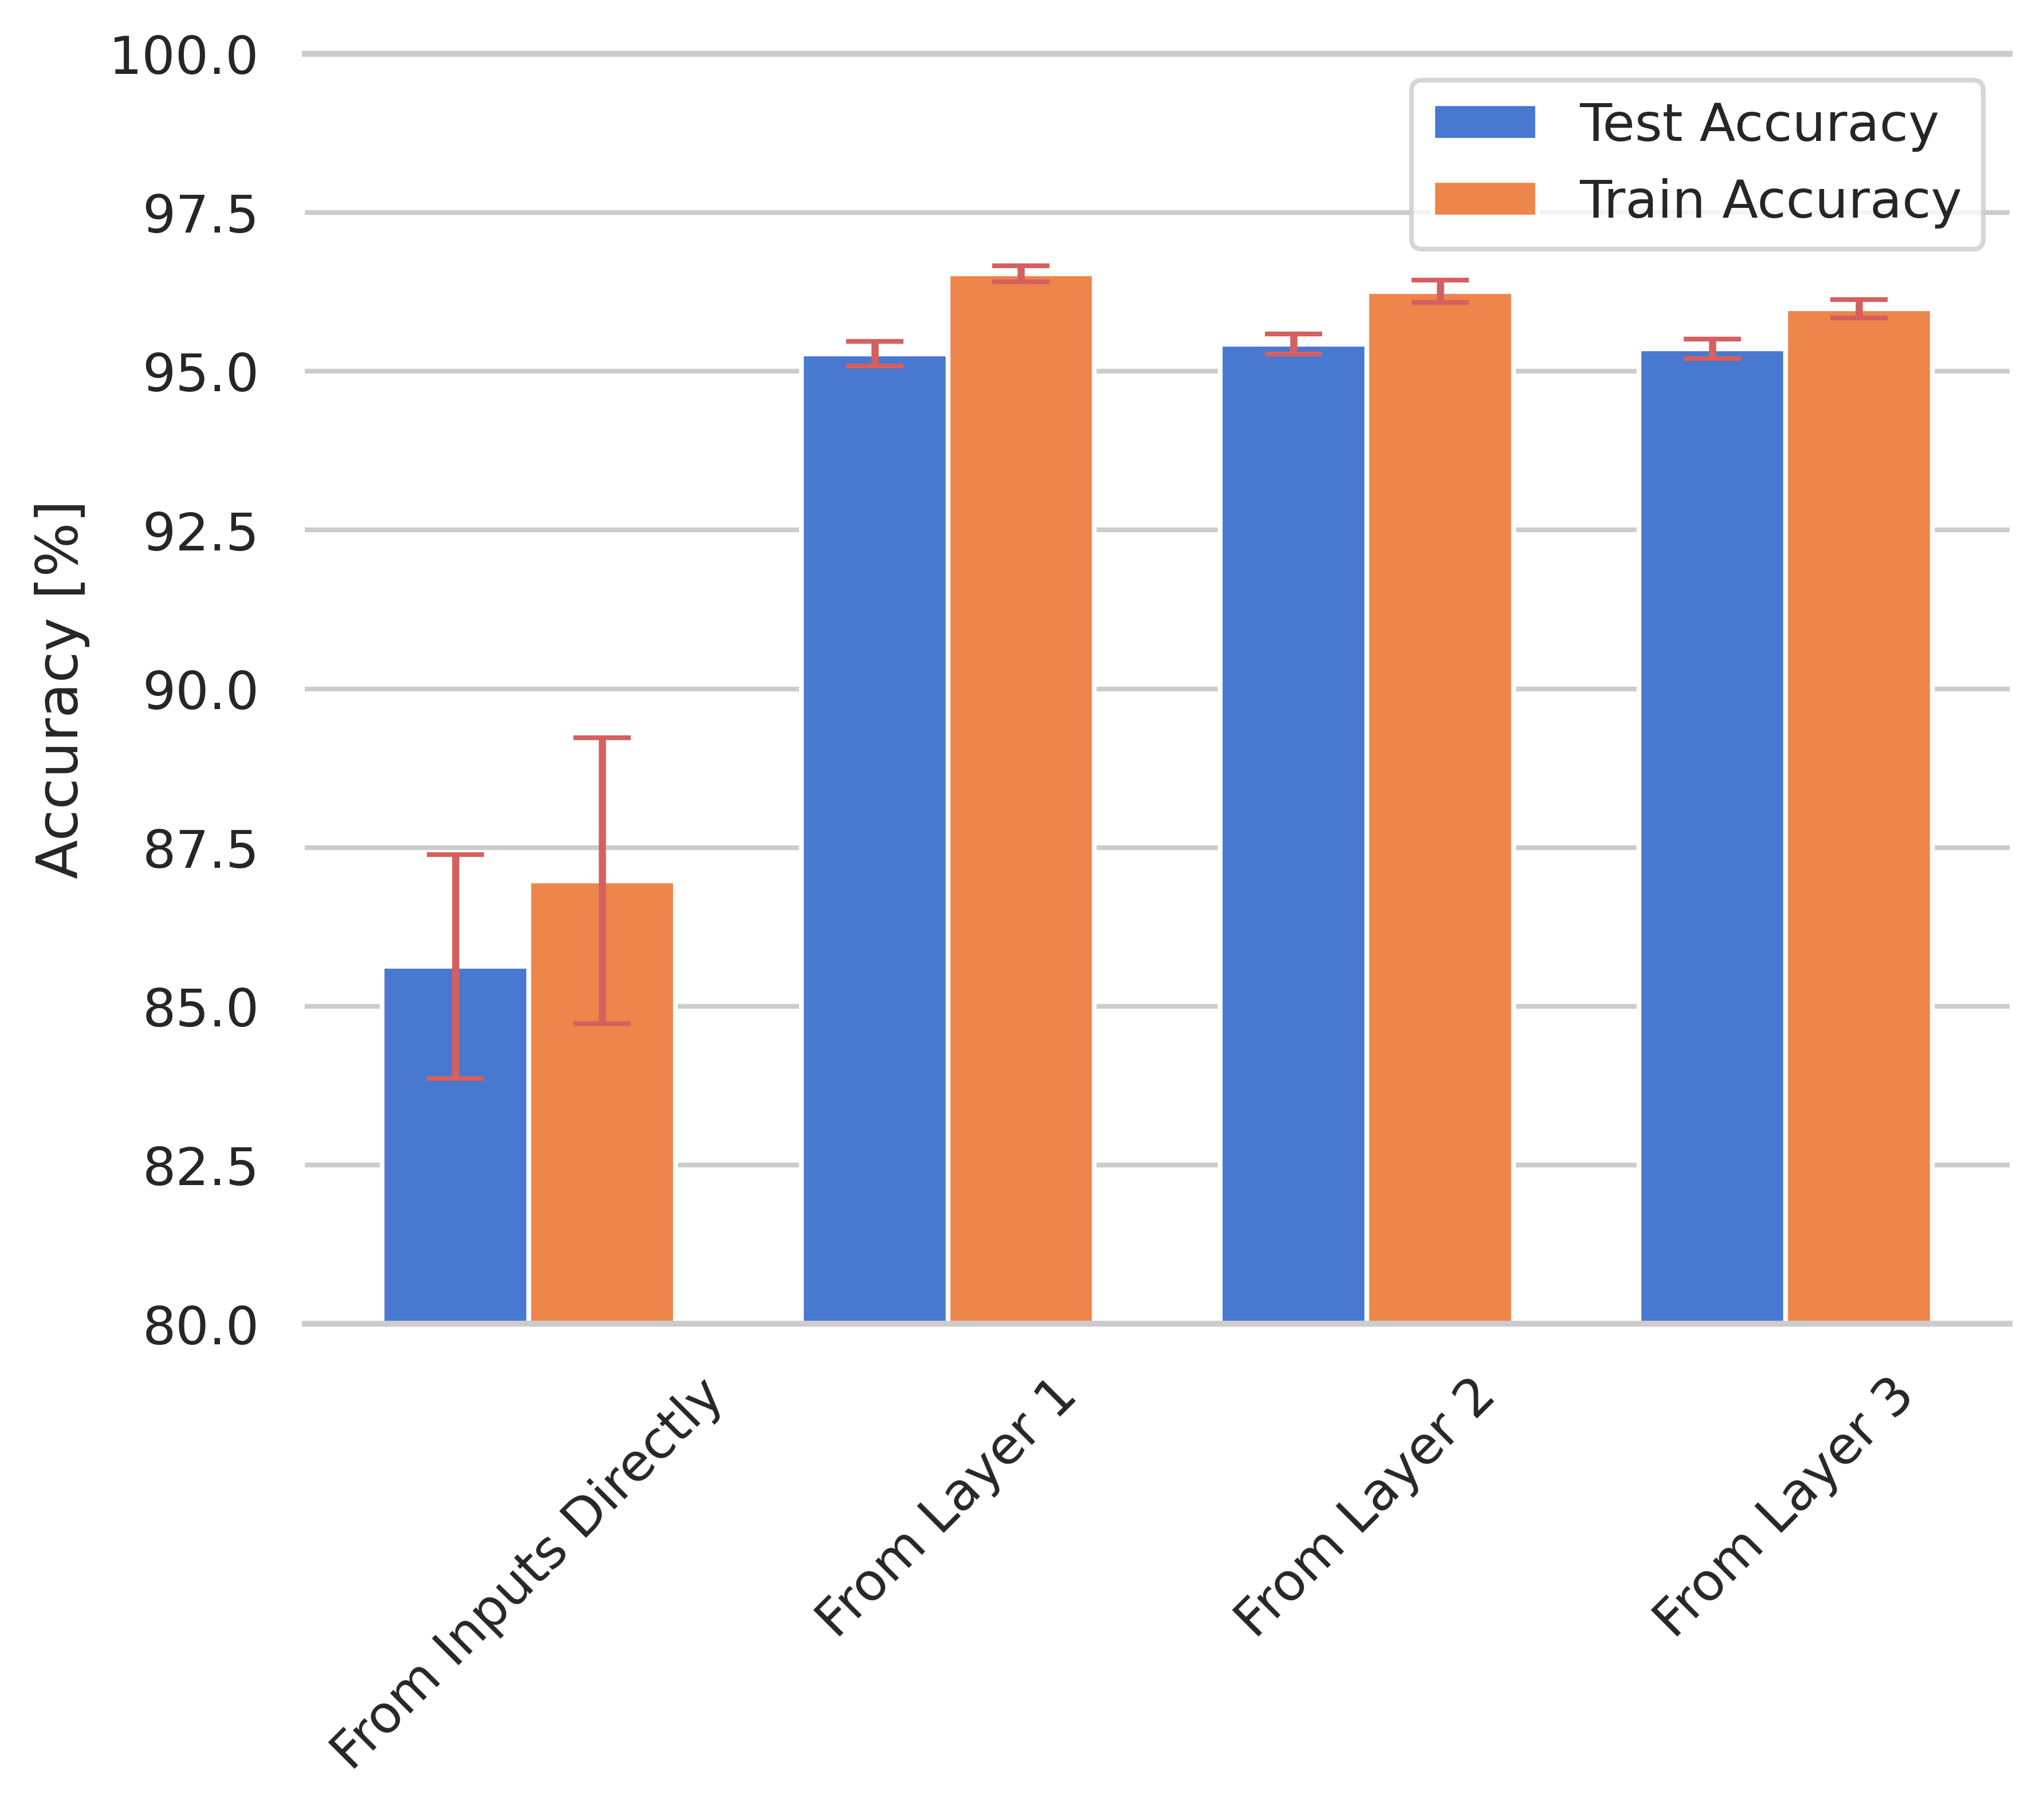

In [13]:
train_accs = torch.stack(train_accs)
test_accs = torch.stack(test_accs)
print(train_accs.shape)
print(f'Train Accuracy: {100*train_accs.mean(axis=0)}%, Std: {100*train_accs.std(axis=0)}%')
print(f'Test Accuracy: {100*test_accs.mean(axis=0)}%, Std: {100*test_accs.std(axis=0)}%')
with open('final_results/' + model_name[:-3] + '_accuracies.pkl', 'wb') as f:
    accs = {'train': train_accs, 'test': test_accs}
    pickle.dump(accs, f)
# grouped Bar plot the Accuracies of the different layers both during training and testing
sns.set_theme(style="whitegrid")
labels = ['From Inputs Directly', *[f'From Layer {i+1}' for i in range(len(SNN.layers))]]
x = torch.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
print(x.shape, train_accs.mean(axis=0).shape)
rects1 = ax.bar(x - width/2, 100*test_accs.mean(axis=0), width, label='Test Accuracy', color=color_list[0])
ax.errorbar(x - width/2, 100*test_accs.mean(axis=0), yerr=100*test_accs.std(axis=0), fmt='none', capsize=6, color=color_list[3])
rects2 = ax.bar(x + width/2, 100*train_accs.mean(axis=0), width, label='Train Accuracy', color=color_list[1])
ax.errorbar(x + width/2, 100*train_accs.mean(axis=0), yerr=100*train_accs.std(axis=0), fmt='none', capsize=6, color=color_list[3])
# remove horizontal lines and spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.grid(False)
plt.xticks(np.arange(len(out_projs)), labels, rotation=45)
plt.legend()
plt.ylabel('Accuracy [%]')
plt.ylim([80, 100])
print(fig.get_size_inches())


# Few-Shot

In [10]:
n_repeats = 10
fewshot_accuracies = torch.zeros((n_repeats, len(SNN.layers)))
for n in range(n_repeats):
    # Randomly select one sample of each class and save the spiking activity
    SNN.reset(0)
    one_shot_samples = torch.zeros(args.n_outputs, args.n_time_bins, args.n_inputs)
    one_shot_spks = [torch.zeros(args.n_outputs, h) for h  in args.n_hidden]
    k = 20
    for i in range(args.n_outputs):
        for j in range(k):
            img, _ = train_loader2.next_item(i, contrastive=False)
            one_shot_samples[i] = img.squeeze()
            for t in range(args.n_time_bins):
                logits, _, _ = SNN(img[t].float(), 0)
                for idx, log in enumerate(logits):
                    one_shot_spks[idx][i] += log.squeeze()

    def metric(spk, one_shot):
        dists = torch.zeros(spk.shape[0], args.n_outputs)
        for i in range(args.n_outputs):
            one_shot_i = one_shot[i] / one_shot[i].sum()
            dists[:, i] = torch.einsum('bi, i->b' , spk, one_shot_i)
        return dists

    def get_predictions(spks):
        preds = torch.zeros(len(spks), spks[0].shape[0])
        # for each layer get the prediction
        for i in range(len(spks)):
            dists = metric(spks[i], one_shot_spks[i])
            preds[i] = dists.argmax(axis=-1)
        return preds

    batch = int(len(test_loader)/10)
    correct_oneshot = torch.zeros(len(SNN.layers))
    SNN.eval()
    pred_matrix_oneshot = torch.zeros(args.n_outputs, args.n_outputs)
    for idx in trange(0, len(test_loader), batch):
        SNN.reset(0)
        if args.dataset == 'mnist':
            inp, target = test_loader.x[idx:idx+batch], test_loader.y[idx:idx+batch]
        else:
            until = min(batch, len(test_loader.data) - idx)
            inp = torch.stack([torch.tensor(test_loader.data[idx+i][0]).view(args.n_time_bins, -1) for i in range(until)])
            target = torch.tensor([test_loader.data[idx+i][1] for i in range(until)])
        logits = [torch.zeros(inp.shape[0], h) for h  in args.n_hidden]
        for step in range(inp.shape[1]):
            data_step = inp[:,step].float().to(device)
            spk_step, _, _ = SNN(data_step, 0)
            for logidx in range(len(spk_step)):
                logits[logidx] += spk_step[logidx]
        preds = get_predictions(logits)
        for i in range(preds.shape[0]):
            correct_oneshot[i] += int((preds[i] == target).sum())
        # for the last layer create the prediction matrix
        for j in range(preds.shape[1]):
            pred_matrix_oneshot[int(target[j]), int(preds[-1, j])] += 1
    correct_oneshot /= len(test_loader)
    for i in range(len(SNN.layers)):
        print(f'From layer {i+1}:')
        print(f'Accuracy: {100*correct_oneshot[i]:.2f}%')
    fewshot_accuracies[n] = correct_oneshot
    # plt.imshow(pred_matrix_oneshot, origin='lower')
    # plt.title('Prediction Matrix for the final layer')
    # plt.xlabel('Prediction')
    # plt.ylabel('Target')
    # plt.xticks([i for i in range(args.n_outputs)])
    # plt.yticks([i for i in range(args.n_outputs)])
    # plt.colorbar();
    # plt.show()
    print(f'Accuracy per Label: {100*pred_matrix_oneshot.diag()/pred_matrix_oneshot.sum(axis=1)}%') # correct axis?

  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.09%
From layer 2:
Accuracy: 95.23%
From layer 3:
Accuracy: 95.37%
Accuracy per Label: tensor([98.5714, 98.2379, 95.1550, 94.0594, 96.7413, 93.8341, 96.1378, 93.3852,
        94.6612, 92.5669])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.27%
From layer 2:
Accuracy: 95.23%
From layer 3:
Accuracy: 95.33%
Accuracy per Label: tensor([98.5714, 98.3260, 95.2519, 94.7525, 96.7413, 93.8341, 95.5115, 92.7043,
        94.4558, 92.7651])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 93.99%
From layer 2:
Accuracy: 95.10%
From layer 3:
Accuracy: 95.24%
Accuracy per Label: tensor([98.4694, 98.3260, 93.5078, 93.4653, 96.5377, 94.6188, 97.0772, 93.1907,
        94.6612, 92.3687])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.28%
From layer 2:
Accuracy: 95.23%
From layer 3:
Accuracy: 95.37%
Accuracy per Label: tensor([98.0612, 98.5903, 93.7984, 94.1584, 96.5377, 94.0583, 97.1816, 93.9689,
        94.5585, 92.4678])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.15%
From layer 2:
Accuracy: 95.08%
From layer 3:
Accuracy: 95.32%
Accuracy per Label: tensor([98.4694, 98.3260, 94.6705, 93.8614, 96.5377, 94.6188, 96.6597, 93.3852,
        93.9425, 92.4678])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 93.39%
From layer 2:
Accuracy: 94.92%
From layer 3:
Accuracy: 95.20%
Accuracy per Label: tensor([98.5714, 98.5903, 92.4419, 94.3564, 96.9450, 93.8341, 96.4509, 93.8716,
        94.2505, 92.3687])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.12%
From layer 2:
Accuracy: 95.08%
From layer 3:
Accuracy: 95.23%
Accuracy per Label: tensor([98.5714, 98.3260, 93.6047, 94.4554, 96.6395, 93.9462, 96.5553, 93.4825,
        94.2505, 92.1705])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 93.55%
From layer 2:
Accuracy: 95.12%
From layer 3:
Accuracy: 95.13%
Accuracy per Label: tensor([98.6735, 98.3260, 93.9922, 94.2574, 96.6395, 94.3946, 94.4676, 93.3852,
        94.3532, 92.4678])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 93.66%
From layer 2:
Accuracy: 94.91%
From layer 3:
Accuracy: 95.24%
Accuracy per Label: tensor([98.5714, 98.4141, 92.5388, 94.0594, 96.5377, 94.3946, 97.0772, 94.3580,
        94.0452, 92.1705])%


  0%|          | 0/10 [00:00<?, ?it/s]

From layer 1:
Accuracy: 94.39%
From layer 2:
Accuracy: 95.27%
From layer 3:
Accuracy: 95.40%
Accuracy per Label: tensor([98.6735, 98.5022, 95.2519, 94.1584, 96.7413, 94.0583, 96.4509, 93.4825,
        94.0452, 92.2696])%


Average Accuracy: tensor([93.9890, 95.1170, 95.2830])%
Maximum Accuracy: torch.return_types.max(
values=tensor([0.9439, 0.9527, 0.9540]),
indices=tensor([9, 9, 9]))%


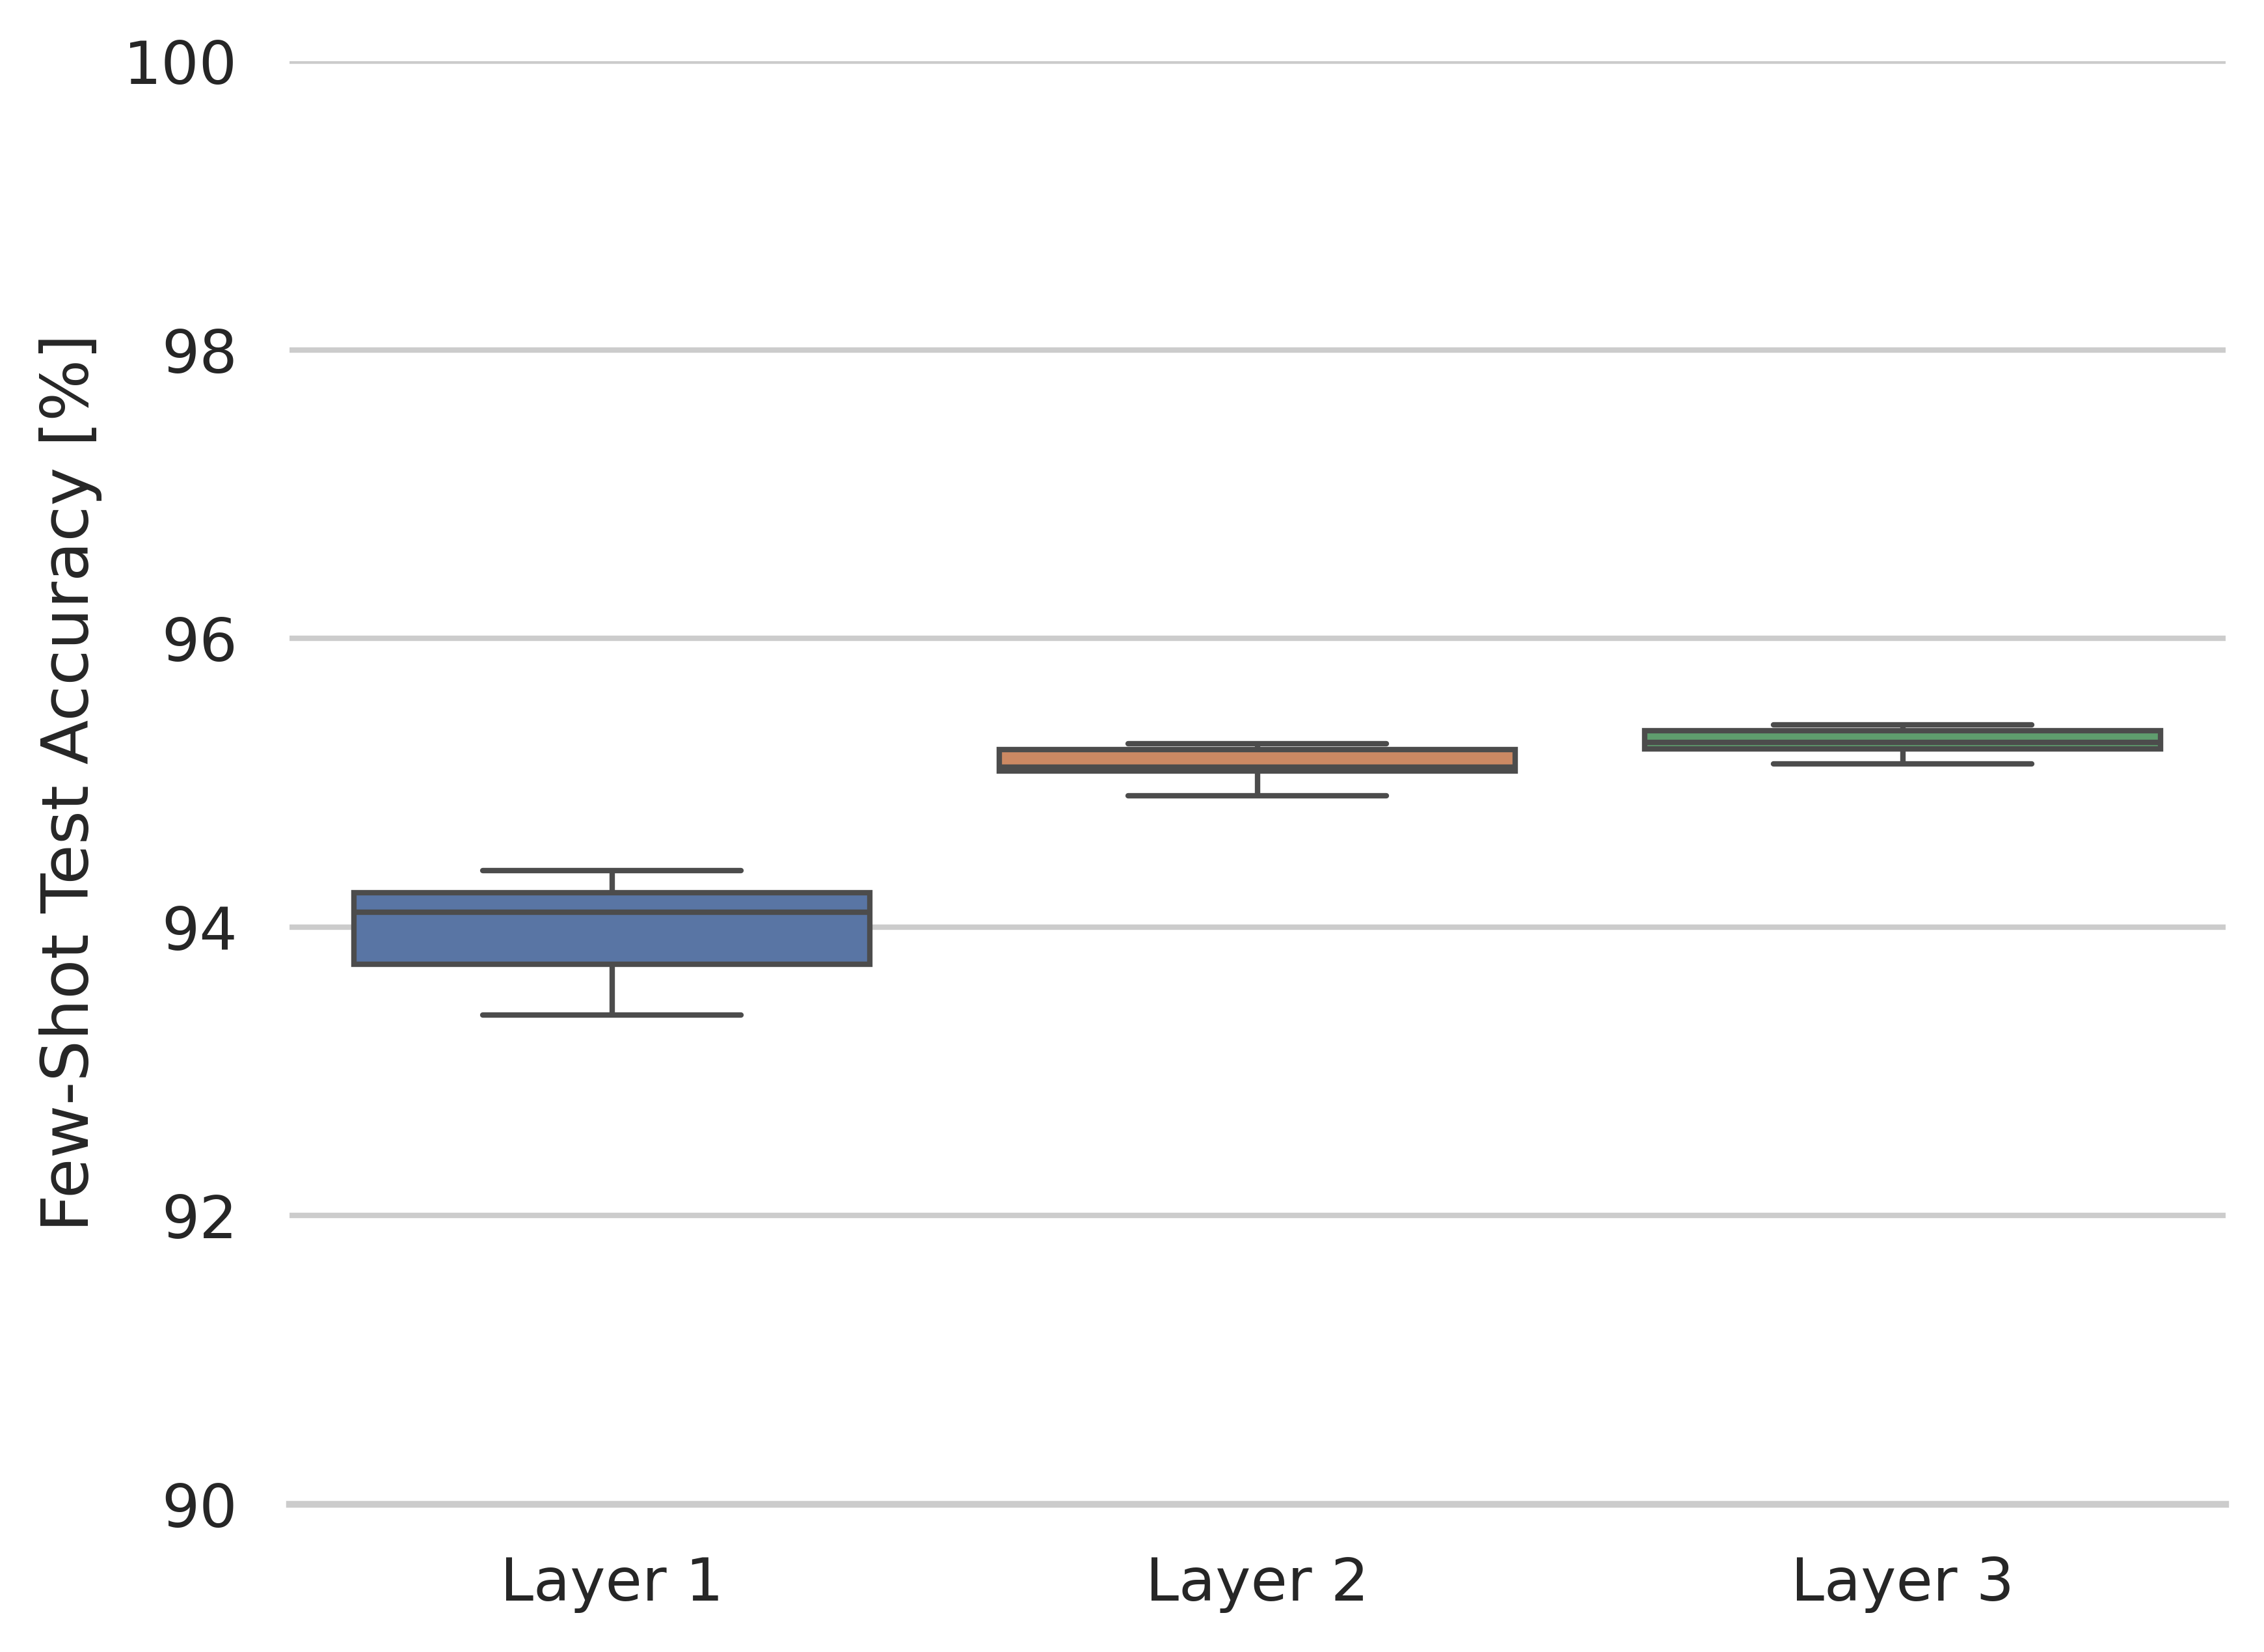

In [11]:
with open('final_results/' + model_name[:-3] + '_fewshot_accuracies.pkl', 'wb') as f:
    pickle.dump(fewshot_accuracies, f)
# Boxplot of the accuracies
plt.figure(figsize=(6.4,4.8))
sns.set_style("whitegrid")
g = sns.boxplot(data=fewshot_accuracies*100,)
# remove left spines
sns.despine(left=True)
plt.xticks(np.arange(len(SNN.layers)), [f'Layer {i+1}' for i in range(len(SNN.layers))])
plt.ylabel('Few-Shot Test Accuracy [%]')
plt.ylim([90, 100])
print(f'Average Accuracy: {100*fewshot_accuracies.mean(axis=0)}%')
print(f'Maximum Accuracy: {fewshot_accuracies.max(axis=0)}%')